In [8]:

import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage.filters import convolve as filter2
import os
from argparse import ArgumentParser

<ipython-input-8-961b750b4554>:4: DeprecationWarning: Please import `convolve` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import convolve as filter2


In [9]:

def show_image(name, image):
    if image is None:
        return

    cv2.imshow(name, image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [10]:
#compute magnitude in each 8 pixels. return magnitude average
def get_magnitude(u, v):
    scale = 3
    sum = 0.0
    counter = 0.0

    for i in range(0, u.shape[0], 8):
        for j in range(0, u.shape[1],8):
            counter += 1
            dy = v[i,j] * scale
            dx = u[i,j] * scale
            magnitude = (dx**2 + dy**2)**0.5
            sum += magnitude

    mag_avg = sum / counter

    return mag_avg

In [11]:
def draw_quiver(u,v,beforeImg):
    scale = 3
    ax = plt.figure().gca()
    ax.imshow(beforeImg, cmap = 'gray')

    magnitudeAvg = get_magnitude(u, v)

    for i in range(0, u.shape[0], 8):
        for j in range(0, u.shape[1],8):
            dy = v[i,j] * scale
            dx = u[i,j] * scale
            magnitude = (dx**2 + dy**2)**0.5
            #draw only significant changes
            if magnitude > magnitudeAvg:
                ax.arrow(j,i, dx, dy, color = 'red')

    plt.draw()
    plt.show()


In [12]:
#compute derivatives of the image intensity values along the x, y, time
def get_derivatives(img1, img2):
    #derivative masks
    x_kernel = np.array([[-1, 1], [-1, 1]]) * 0.25
    y_kernel = np.array([[-1, -1], [1, 1]]) * 0.25
    t_kernel = np.ones((2, 2)) * 0.25

    fx = filter2(img1,x_kernel) + filter2(img2,x_kernel)
    fy = filter2(img1, y_kernel) + filter2(img2, y_kernel)
    ft = filter2(img1, -t_kernel) + filter2(img2, t_kernel)

    return [fx,fy, ft]

In [13]:
#input: images name, smoothing parameter, tolerance
#output: images variations (flow vectors u, v)
#calculates u,v vectors and draw quiver
def computeHS(name1, name2, alpha, delta):
    path = "/content/test images"
    beforeImg = cv2.imread(os.path.join(path, name1), cv2.IMREAD_GRAYSCALE)
    afterImg = cv2.imread(os.path.join(path, name2), cv2.IMREAD_GRAYSCALE)

    if beforeImg is None:
        raise NameError("Can't find image: \"" + name1 + '\"')
    elif afterImg is None:
        raise NameError("Can't find image: \"" + name2 + '\"')

    beforeImg = cv2.imread(os.path.join(path, name1), cv2.IMREAD_GRAYSCALE).astype(float)
    afterImg = cv2.imread(os.path.join(path, name2), cv2.IMREAD_GRAYSCALE).astype(float)

    #removing noise
    beforeImg  = cv2.GaussianBlur(beforeImg, (5, 5), 0)
    afterImg = cv2.GaussianBlur(afterImg, (5, 5), 0)

    # set up initial values
    u = np.zeros((beforeImg.shape[0], beforeImg.shape[1]))
    v = np.zeros((beforeImg.shape[0], beforeImg.shape[1]))
    fx, fy, ft = get_derivatives(beforeImg, afterImg)
    avg_kernel = np.array([[1 / 12, 1 / 6, 1 / 12],
                            [1 / 6, 0, 1 / 6],
                            [1 / 12, 1 / 6, 1 / 12]], float)
    iter_counter = 0
    while True:
        iter_counter += 1
        u_avg = filter2(u, avg_kernel)
        v_avg = filter2(v, avg_kernel)
        p = fx * u_avg + fy * v_avg + ft
        d = 4 * alpha**2 + fx**2 + fy**2
        prev = u

        u = u_avg - fx * (p / d)
        v = v_avg - fy * (p / d)

        diff = np.linalg.norm(u - prev, 2)
        #converges check (at most 300 iterations)
        if  diff < delta or iter_counter > 300:
            # print("iteration number: ", iter_counter)
            break

    draw_quiver(u, v, beforeImg)

    return [u, v]

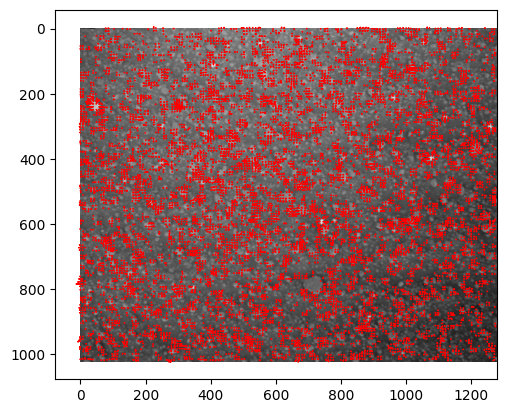

In [15]:
if __name__ == '__main__':
    #parser = ArgumentParser(description = 'Horn Schunck program')
    #parser.add_argument('img1', type = str, help = 'First image name (include format)')
    #parser.add_argument('img2', type = str, help='Second image name (include format)')
    #args = parser.parse_args()

    u,v = computeHS("/content/img1.bmp", "/content/img2.bmp", alpha = 15, delta = 10**-1)